In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import pandas as pd
from sklearn.metrics import accuracy_score, make_scorer, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from functions import *

pd.set_option('display.max_columns', None)

df_merged = pd.read_csv(r"../data/df_merged_national.csv")

df_poblacion = pd.read_csv(r"../data/cleaned_pop.csv")


In [42]:
df_merged = clean_df(df_merged)
df_merged = every_float_to_int(df_merged)

In [43]:
df_no_provincias = df_merged[(df_merged["region"] == "    DESCONOCIDA") | (df_merged["region"] == "    EN EL EXTRANJERO") | (df_merged["region"] == "    TOTAL NACIONAL")]

df_no_provincias.to_csv("../data/df_no_provincias.csv", index=False)

In [44]:
df_merged = df_merged[~df_merged.index.isin(df_no_provincias.index)]

In [45]:
df_num = df_merged.iloc[:, df_merged.columns != 'region']

In [46]:
df_merged = add_coordinates_from_dict(df_merged)

In [47]:
df_merged["region"] = convert_region_into_numeric(df_merged["region"], True)

c:\Users\VSPC\Documents\GitHub\Project6\notebooks\functions.py:185: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df_col.replace(regions)


In [48]:
df_merged.insert(0, "year", df_merged.pop("year"))

In [49]:
df_merged = delete_sub_crimes(df_merged)

In [50]:
df_merged["avg_crimes"] = df_merged.iloc[:, 2:-3].mean(axis=1)      # [:, 2:-2] quiero -> todas las filas, desde la 2da hasta la penultima columna

In [51]:
df_poblacion.drop(["Nacional", "Sexo"], inplace=True, axis=1)

df_poblacion["region"] = convert_region_into_numeric(df_poblacion["region"], False)

c:\Users\VSPC\Documents\GitHub\Project6\notebooks\functions.py:185: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  return df_col.replace(regions)


In [52]:
df_merged = df_merged.merge(df_poblacion, on=["region", "year"])

df_merged.rename(columns={"Total": "population"}, inplace=True)

In [53]:
crime_values = ['1_against_people', '2_against_freedom',
       '3_sexual_freedom', '4_family_relationships', '5_property_crimes',
       '6_collective_security', '7_forgeries', '8_public_administration',
       '9_justice_administration']

In [54]:
df_unpivot = pd.melt(df_merged, id_vars=['year', 'region', 'latitude', 'longitude', 'population'], value_vars=crime_values)

In [55]:
df_unpivot_transformed = df_unpivot.copy()

for crime in crime_values:
    column_name = f'{crime}_indicator'
    df_unpivot_transformed[column_name] = (df_unpivot_transformed['variable'] == crime).astype(int)


In [56]:
df_values = get_previous_years(df_unpivot_transformed)


In [57]:
df_total_values = df_values.dropna(subset=['values_year_minus_1', 'values_year_minus_2', 'values_year_minus_3']).reset_index(drop=True)

In [58]:
columns_pca = ['values_year_minus_1', 'values_year_minus_2', 'values_year_minus_3']

df_total_values = apply_pca(df_total_values, columns_pca)

df_total_values["population"] = df_total_values["population"].replace("\.", "", regex=True).astype(int)

df_total_values.drop(columns=["region"], inplace=True)

<>:5: SyntaxWarning: invalid escape sequence '\.'
<>:5: SyntaxWarning: invalid escape sequence '\.'
C:\Users\VSPC\AppData\Local\Temp\ipykernel_24284\94342031.py:5: SyntaxWarning: invalid escape sequence '\.'
  df_total_values["population"] = df_total_values["population"].replace("\.", "", regex=True).astype(int)


In [59]:
plt.figure(figsize=(15, 12));
# sns.heatmap(df_total_values_201017.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)    

<Figure size 1500x1200 with 0 Axes>

# Obtención de X_train, X_test, y_train, y_test

In [60]:
df_total_values_201017 = df_total_values[df_total_values['year'] <= 2017]

df_total_values_201819 = df_total_values[df_total_values['year'] >= 2018]

In [61]:
features = [
    'year','latitude', 'longitude', 'population',
    '1_against_people_indicator', '2_against_freedom_indicator',
    '3_sexual_freedom_indicator', '4_family_relationships_indicator',
    '5_property_crimes_indicator', '6_collective_security_indicator',
    '7_forgeries_indicator', '8_public_administration_indicator',
    '9_justice_administration_indicator', 'Values_year_PCA'
    ]

X_train = df_total_values_201017[features]
y_train = df_total_values_201017['value']

X_test = df_total_values_201819[df_total_values_201819['year'] == 2018][features]
y_test = df_total_values_201819[df_total_values_201819['year'] == 2018]['value']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((855, 14), (855,), (171, 14), (171,))

### Use Random Forest

In [62]:
rf_reg = RandomForestRegressor(
    n_estimators=300, 
    max_leaf_nodes=None,
    min_samples_split=5,
    n_jobs=-1, 
    random_state=42
    )

rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)


In [63]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 1033.0388923532064
Root Mean Squared Error (RMSE): 4707.907926358282
R² Score: 0.9896681902859178


### Random Forest Hyperparameter Tunning

In [64]:
X_train = df_total_values_201017[features]
y_train = df_total_values_201017['value']

X_test = df_total_values_201819[df_total_values_201819['year'] == 2018][features]
y_test = df_total_values_201819[df_total_values_201819['year'] == 2018]['value']

rf_base = RandomForestRegressor(random_state=42)

rf_params = {
    'n_estimators': [100, 300, 500, 800, 1000, 2000],          
    'max_features': ['auto', 'sqrt', 'log2'],            
    'max_depth': [None, 10, 20, 30, 40, 50],              
    'min_samples_split': [2, 5, 10],                      
    'min_samples_leaf': [1, 2, 4],                        
    'bootstrap': [True, False]                            
    }

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_params,
    n_iter=50,  
    scoring='neg_mean_squared_error',  
    cv=3,  
    verbose=2,  
    random_state=42,
    n_jobs=-1
    )

random_search.fit(X_train, y_train)

print(f"Best hyperparameters: {random_search.best_params_}")


y_pred_test = random_search.best_estimator_.predict(X_test)
test_mse = root_mean_squared_error(y_test, y_pred_test)

print(f"Best model: {test_mse}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\VSPC\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
36 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\VSPC\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\VSPC\anaconda3\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\VSPC\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\VSPC\anaconda3\Lib\site-packages\skle

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False}
Best model: 4369.038006154812


### Apply model for predict 2020 and 2021

In [65]:
columns_pca = ['values_year_minus_1', 'values_year_minus_2', 'values_year_minus_3']

#We comeback to the original dataframe with all the information
df_total_values = df_unpivot_transformed

df_total_values['population'] = df_total_values['population'].str.replace('.', '', regex=False).astype(float)

df_total_values = get_previous_years(df_total_values)

df_total_values_PCA = apply_pca(df_total_values, columns_pca)

X_train = df_total_values_PCA[features]
y_train = df_total_values_PCA['value']

X_test = df_total_values_PCA[df_total_values_PCA['year'] == 2019][features]

In [66]:
df_total_predict_202021 = df_total_values_PCA.copy()

best_rf_model = random_search.best_estimator_

future_years = [2020, 2021]

for year in future_years:

    #Drop PCA var
    df_total_predict_202021 = df_total_predict_202021.drop(columns=['Values_year_PCA'], errors='ignore')

    #Recalculate year_minus
    df_total_predict_202021 = get_previous_years(df_total_predict_202021)

    #Apply PCA
    df_total_predict_202021 = apply_pca(df_total_predict_202021, columns_pca)

    #Predict next year
    X_year = df_total_predict_202021[df_total_predict_202021['year'] == year - 1][features]
    y_pred_year = best_rf_model.predict(X_year)

    new_year_df = df_total_predict_202021[df_total_predict_202021['year'] == year - 1].copy()
    new_year_df['year'] = year
    new_year_df['value'] = y_pred_year

    df_total_predict_202021 = pd.concat([df_total_predict_202021, new_year_df], ignore_index=True)

    y_year = df_total_values[df_total_values['year'] == year]['value']

df_total_predict_202021

,year,region,latitude,longitude,population,variable,value,1_against_people_indicator,2_against_freedom_indicator,3_sexual_freedom_indicator,4_family_relationships_indicator,5_property_crimes_indicator,6_collective_security_indicator,7_forgeries_indicator,8_public_administration_indicator,9_justice_administration_indicator,Values_year_PCA
0,2019,0,37.3873,-5.9869,8414240.0,1_against_people,37130.000000,1,0,0,0,0,0,0,0,0,0.870682
1,2019,1,41.6488,-0.8891,1319291.0,1_against_people,4760.000000,1,0,0,0,0,0,0,0,0,-0.298335
2,2019,2,43.3619,-5.8494,1022800.0,1_against_people,3368.000000,1,0,0,0,0,0,0,0,0,-0.337385
3,2019,3,39.5712,2.6466,1149460.0,1_against_people,8110.000000,1,0,0,0,0,0,0,0,0,-0.187941
4,2019,5,28.2916,-16.6291,2153389.0,1_against_people,12396.000000,1,0,0,0,0,0,0,0,0,-0.016985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,2021,16,42.6954,-1.6761,654214.0,9_justice_administration,488.069722,0,0,0,0,0,0,0,0,1,-0.445348
509,2021,17,43.2630,-2.9349,2207776.0,9_justice_administration,1659.554167,0,0,0,0,0,0,0,0,1,-0.402499
510,2021,18,42.2871,-2.5396,316798.0,9_justice_administration,261.753611,0,0,0,0,0,0,0,0,1,-0.453035
511,2021,9,35.8894,-5.3198,84777.0,9_justice_administration,271.358611,0,0,0,0,0,0,0,0,1,-0.453465


### Try to use Bagging for compare

In [67]:
normalizer = MinMaxScaler()

X_train_norm = normalizer.fit_transform(X_train)        

X_test_norm = normalizer.transform(X_test)

In [68]:
X_train_norm = pd.DataFrame(X_train_norm, columns = X_train.columns)        # Vuelvo a dar formato de df
X_test_norm = pd.DataFrame(X_test_norm, columns = X_test.columns)

In [69]:
bagging_reg_norm = BaggingRegressor(DecisionTreeRegressor(max_depth=20),
                               n_estimators=100,
                               max_samples = 500)

bagging_reg_norm.fit(X_train_norm, y_train)         # Entreno mi modelo

BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=20), max_samples=500,
                 n_estimators=100)

In [70]:
pred_norm = bagging_reg_norm.predict(X_test_norm)

print("MAE", mean_absolute_error(pred_norm, y_test))
print("RMSE", root_mean_squared_error(pred_norm, y_test))
print("R2 score", bagging_reg_norm.score(X_test_norm, y_test))

MAE 414.19210526315777
RMSE 1923.0189904690699
R2 score 0.9982761970333949


# GRAPHS

In [ ]:
import pandas as pd

df = pd.read_csv("data/df_201321_with_202021_predicted.csv")

In [ ]:
df = df.sort_values(by=['year'])

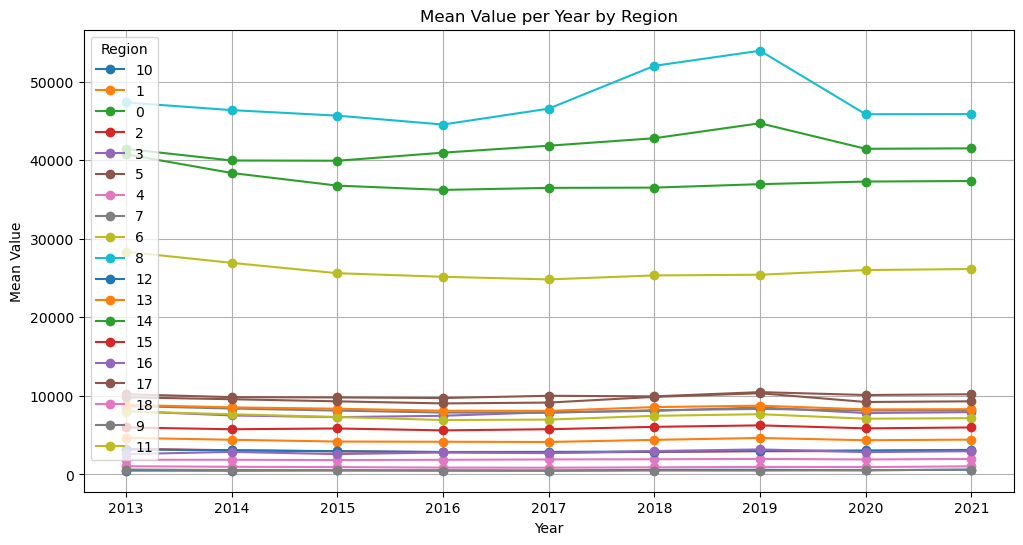

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Graficar los datos para cada región
for region in df['region'].unique():
    region_data = df[df['region'] == region]
    mean_values_per_year = region_data.groupby('year')['value'].mean().reset_index()
    plt.plot(mean_values_per_year['year'], mean_values_per_year['value'], marker='o', linestyle='-', label=region)

# Configurar etiquetas y título
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Mean Value per Year by Region')
plt.legend(title='Region')
plt.grid(True)

# Mostrar el gráfico
plt.show()


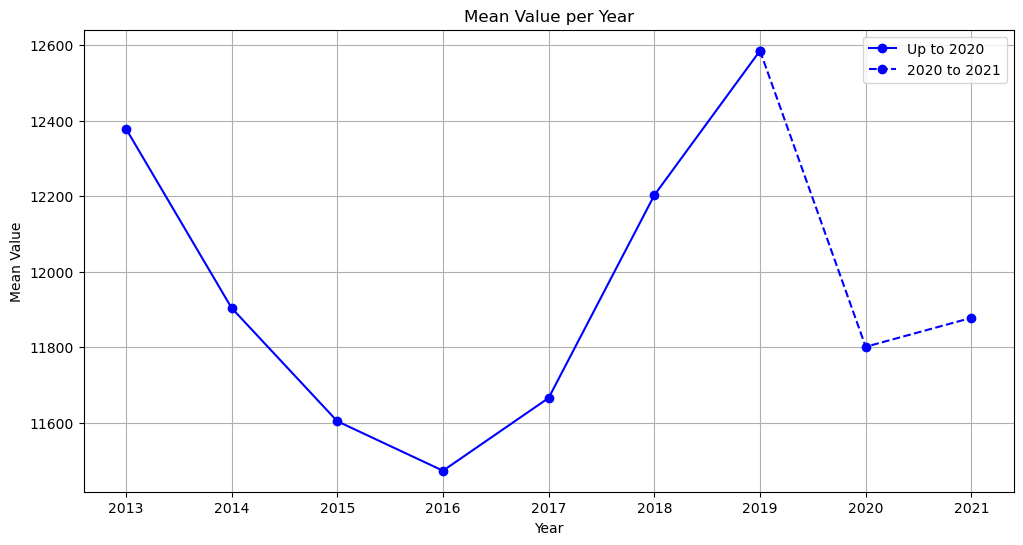

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))
# Calcular el valor medio por año
mean_values_per_year = df.groupby('year')['value'].mean().reset_index()
# Dividir los datos en dos partes: hasta 2019 y desde 2019 a 2020
years_up_to_2019 = mean_values_per_year[mean_values_per_year['year'] <= 2019]
years_2019_to_2020 = mean_values_per_year[(mean_values_per_year['year'] >= 2019) & (mean_values_per_year['year'] <= 2021)]
# Graficar los datos hasta 2019 con línea sólida
plt.plot(years_up_to_2019['year'], years_up_to_2019['value'], marker='o', linestyle='-', color='b', label='Up to 2020')
# Graficar los datos de 2019 a 2020 con línea de puntos
plt.plot(years_2019_to_2020['year'], years_2019_to_2020['value'], marker='o', linestyle='--', color='b', label='2020 to 2021')
# Configurar etiquetas y título
plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Mean Value per Year')
plt.grid(True)
plt.legend()
# Mostrar el gráfico
plt.show()

In [ ]:
df

,year,region,latitude,longitude,population,variable,value,1_against_people_indicator,2_against_freedom_indicator,3_sexual_freedom_indicator,4_family_relationships_indicator,5_property_crimes_indicator,6_collective_security_indicator,7_forgeries_indicator,8_public_administration_indicator,9_justice_administration_indicator,Values_year_PCA,values_year_minus_1,values_year_minus_2,values_year_minus_3
1538,2013,10,35.2930,-2.9387,83679.0,9_justice_administration,43.000000,0,0,0,0,0,0,0,0,1,NaN,69.0,67.0,70.0
1122,2013,1,41.6488,-0.8891,1347150.0,6_collective_security,1225.000000,0,0,0,0,0,1,0,0,0,NaN,1411.0,1640.0,1380.0
1121,2013,0,37.3873,-5.9869,8440300.0,6_collective_security,16119.000000,0,0,0,0,0,1,0,0,0,NaN,17340.0,19296.0,16049.0
456,2013,0,37.3873,-5.9869,8440300.0,1_against_people,56840.000000,1,0,0,0,0,0,0,0,0,NaN,59894.0,64275.0,63795.0
457,2013,1,41.6488,-0.8891,1347150.0,1_against_people,6330.000000,1,0,0,0,0,0,0,0,0,NaN,5987.0,6848.0,6752.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,2021,1,41.6488,-0.8891,1319291.0,4_family_relationships,215.155833,0,0,0,1,0,0,0,0,0,-0.453639,NaN,NaN,NaN
230,2021,2,43.3619,-5.8494,1022800.0,4_family_relationships,181.752778,0,0,0,1,0,0,0,0,0,-0.455926,NaN,NaN,NaN
231,2021,3,39.5712,2.6466,1149460.0,4_family_relationships,259.555833,0,0,0,1,0,0,0,0,0,-0.453169,NaN,NaN,NaN
223,2021,16,42.6954,-1.6761,654214.0,3_sexual_freedom,303.079167,0,0,1,0,0,0,0,0,0,-0.450611,NaN,NaN,NaN


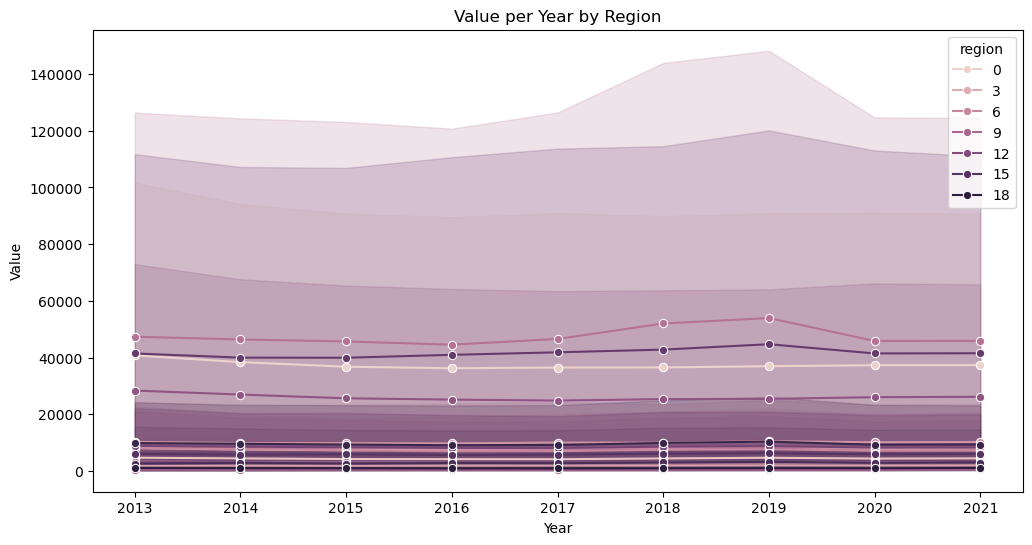

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 6))

# Graficar los datos usando seaborn
sns.lineplot(data=df, x='year', y='value', hue='region', marker='o')

# Configurar etiquetas y título
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Value per Year by Region')

# Mostrar el gráfico
plt.show()


In [ ]:
import pandas as pd
import folium
from folium.plugins import HeatMap


# Asegúrate de que las columnas de latitud y longitud sean float
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)

# Crear un mapa base centrado en la ubicación promedio
map_center = [df['latitude'].mean(), df['longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)

# Preparar datos para el HeatMap
heat_data = [[row['latitude'], row['longitude'], row['value']] for index, row in df.iterrows()]

# Agregar HeatMap al mapa base
HeatMap(heat_data).add_to(m)

# Guardar el mapa en un archivo HTML y mostrarlo
m.save('heatmap.html')

# Para mostrar en Jupyter Notebook (opcional)
m
